# Importing modules and data from SemCor




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
from nltk.corpus import wordnet as wn
from collections import Counter
from nltk.corpus import semcor
import pickle
import numpy as np
import pandas as pd
from operator import itemgetter
import regex as re
from sklearn.model_selection import train_test_split, KFold
from numpy import array
import time
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
    
with open('data/semcor_transformed_data.pkl', 'rb') as handle:
    data_word_synset = pickle.load(handle)
with open('data/word_pos_DS.pkl', 'rb') as handle:
    data_word_pos = pickle.load(handle)

In [ ]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

In [ ]:
eta = 1e-10
def sense_transition(pp, prev, curr):
    global countSense
    global sense_bigram_count
    global sense_trigram_count
    global allSenses
    global sumSense
    global lambdas
    
    sense_uni, sense_bi, sense_tri = 0,0,0
    try:
        sense_uni = countSense[curr]/sumSense
    except:
        pass
    try:
        sense_bi = sense_bigram_count[(prev,curr)]/countSense[prev]
    except:
        pass
    try:
        sense_tri = sense_trigram_count[(pp, prev, curr)]/sense_bigram_count[(pp,prev)]
    except:
        pass
    if (sense_uni+sense_bi+sense_tri) == 0:
        return eta

    return lambdas[0]*sense_tri + lambdas[1]*sense_bi + lambdas[2]*sense_uni

def N_gram(s_list, N=1):
    t = []
    for i in range(len(s_list)- N + 1):
        t.append( tuple(s_list[i:i+N]) )
    return t

def sense_emission(word, sense):
    global word_sense_count
    global word_count
    if (word,sense) not in word_sense_count.keys():
        return eta
    count = word_sense_count[(word,sense)]
    word_count_m = word_count[word] #countSense[sense]
    if word_count_m == 0 :
        return eta
    return count/word_count_m

In [ ]:
def get_all_synsets(word,pos_list):
    syns = wn.synsets(word)
    if syns==[]:
        return ['']
    if '' in pos_list :
        return ['']
    out_syn = []
    for s in syns:
        if s.pos() in pos_list:
            out_syn.append(s.name())
    if out_syn == []:
        return ['']
    return out_syn

In [ ]:
def sense_assign_viterbi(words_list, pos_list):

    prev_sense = ['']
    p_prev_sense = ['']
    V = {}
    path = {}

    V[-1,'',''] = 1
    path['',''] = []
    for i in range(len(words_list)):

        temp_path ={}


        cur_sense = get_all_synsets(words_list[i], pos_list[i])


        for p_sense in prev_sense: #u
            for c_sense in cur_sense: #v
                #w
                V[i,p_sense,c_sense],pp_s = max(
                    [(
                        V[i-1,pp_sense,p_sense]*sense_transition(pp_sense,p_sense,c_sense)*sense_emission(words_list[i],c_sense),
                      pp_sense
                      ) for pp_sense in p_prev_sense
                     ]
                      )
                temp_path[p_sense, c_sense] = path[pp_s,p_sense] + [c_sense]

            
        path = temp_path 
        p_prev_sense = prev_sense
        prev_sense = cur_sense
    
    prob, umax, vmax = max([(V[len(words_list)-1,pp_s,p_s],pp_s,p_s) for pp_s in p_prev_sense for p_s in prev_sense ])

    #max([(get_V(V,len(sent),u,v) * get_transition(transitionProbTable,u,v,'.'),u,v) for u in allTags for v in allTags])
        
    # print(prob)
    
    return path[umax, vmax]



In [ ]:
def deleted_interpolation():
    global countSense
    global sense_trigram_count
    global sense_bigram_count
    global sumSense
    l1 = l2 = l3 = 0

    triplets = sense_trigram_count.keys() 
    for a,b,c in triplets:
        triCount = sense_trigram_count[(a,b,c)]
        if triCount > 0:
            try: 
                k1 = (triCount-1)/(sense_bigram_count[(a,b)] - 1)
            except :
                k1 = 0.0
            try:
                k2 = (sense_bigram_count[(a,b)] - 1)/( countSense[a] - 1)
            except :
                k2 = 0.0
            try:
                k3 = ( countSense[a] - 1)/(sumSense -1)
            except :
                k3 = 0.0
            
            k = np.argmax([k1, k2, k3])
            if k==0:
                l1 += triCount
            if k==1:
                l2 += triCount
            if k==2:
                l3 += triCount
    wts = [l1, l2, l3]
    return [l/(sum(wts)) for l in wts]

In [ ]:
def get_mfs(ws_count):
  word_all_senses = {}
  for k,v in zip(ws_count.keys(), ws_count.values()):
    if k[0] in word_all_senses.keys():
      if k[1] in word_all_senses[k[0]].keys():
        word_all_senses[k[0]][k[1]] += v
      else:
        word_all_senses[k[0]][k[1]] = v
    else:
      word_all_senses[k[0]] = {}
      word_all_senses[k[0]][k[1]] = v
  return word_all_senses

In [ ]:
def train(train_set):
    global allSenses
    global train_data
    global countSense
    global word_sense_count
    global word_count
    global sense_bigram_count
    global sense_trigram_count
    global word_mfs
    global sumSense
    global lambdas

    train_data = train_set
    allSenses = {sense for sent in train_data for _,sense,_ in sent}
    countSense = Counter([t for sent in train_data for _,t,_ in sent])
    sumSense = sum(countSense.values())
    word_sense_count = Counter([(w,s) for sent in train_data for w,s,_ in sent])
    word_count = Counter([w for sent in train_data for w,_,_ in sent])
    word_mfs = get_mfs(word_sense_count)
    
    sense_bigram = []
    sense_trigram = []
    for sent in train_data:
        t = [s for _,s,_ in sent]
        sense_bigram += N_gram(t, N=2)
        sense_trigram += N_gram(t, N=3)

    sense_bigram_count = Counter(sense_bigram)
    sense_trigram_count = Counter(sense_trigram)

    lambdas = deleted_interpolation()
    

In [ ]:
def mfs(word,pos):
    global word_mfs
    word = word.lower()
    if word not in word_mfs.keys():
      return ''
    word_senses_count = word_mfs[word]
    if word_senses_count == {} : return ''
    # return word_senses_count.keys()
    syns = get_all_synsets(word,pos)
    t = {k:v for k,v in word_senses_count.items() if k in syns}
    word_senses_count = t
    if word_senses_count == {} : return ''
    s = max(word_senses_count, key=word_senses_count.get)
    if s == '' and len(word_senses_count) > 1:
        word_senses_count.pop('', None)
        return max(word_senses_count, key=word_senses_count.get)
    return s
def test_mfs(test_set):
  out_s = []
  for sent in test_set:
    out_s += [mfs(w,p) for w,_,p in sent]
  return out_s


def WFS(word,pos_list):
    global word_mfs
    # pos_list = ['n','s','a','v','r','']
    word = word.lower()
    s = get_all_synsets(word,pos_list)
    return s[0]
    

def test_WFS(test_set):
  out_s = []
  for sent in test_set:
    out_s += [WFS(w,p) for w,_,p in sent]
  return out_s



In [ ]:
def test(test_set):
    inp_s = []
    out_s = []
    for sent in test_set:
        sent_word = [w for w,_,_ in sent]
        inp_s    += [s for _,s,_ in sent]
        sent_pos  = [p for _,_,p in sent]
        out_s += sense_assign_viterbi(sent_word, sent_pos)
    return inp_s, out_s

In [ ]:
#semcor data transformation
def wordnet_pos_code(tag):
    if tag.startswith('NN'):
        return [wn.NOUN]
    elif tag.startswith('VB'):
        return [wn.VERB]
    elif tag.startswith('JJ'):
        return [wn.ADJ, wn.ADJ_SAT]
    elif tag.startswith('RB'):
        return [wn.ADV]
    else:
        return ['']

def word_pos(sent):
    out_sent = []
    for l in sent:
        w = []
        p = set()
        for tup in l:
            w.append(tup[0])
            p.add(tup[1])
        if None in p:
            p = {''}
        p = list(p)
        o_tag = []
        for tag in p:
            t = tag.split('|')
            for tg in t:
                o_tag.extend(wordnet_pos_code(tg))
        out_sent.append(('_'.join(w),list(set(o_tag))))
    return out_sent

def join_word_syn_pos(word_syn, word_pos):
    # sent wise join
    out_sent = []
    for tup_ws, tup_wp in zip(word_syn, word_pos):
        out_sent.append((tup_wp[0].lower(), tup_ws[1], tup_wp[1]))
    return out_sent

def word_synset_tuple(sent):
    out_tup = []
    for l in sent:
        if isinstance(l, nltk.tree.Tree):
            if hasattr(l.label(), '_name') :
                w,s = l.label().name(),l.label().synset().name()
            else :
                w,s = l.label().split('.')[0], ''
        else :
            w,s = l[0], ''
        out_tup.append( (w.lower(), s) )
    return out_tup
    
# uncomment to load your nltk_data and transform it
#nltk_data = list(semcor.tagged_sents(tag='sem'))
#data_word_synset = [word_synset_tuple(sent) for sent in nltk_data]

#x = semcor.tagged_sents(tag='pos')
#y = [[w.pos() for w in sent] for sent in x]
#data_word_pos = [word_pos(sent) for sent in y]

In [ ]:
semCorData = [join_word_syn_pos(sent_syn, sent_pos) for sent_syn, sent_pos in zip(data_word_synset, data_word_pos)]

In [ ]:
nltk_data = array(semCorData,dtype=object)

#Specifiying K for K-fold cross validations as 5
K_folds = KFold(5, True, 1)
actual_tags = []
predicted_tags =[]

mfs_output = []
wfs_output = []
i = 1
#Training  5 sets of predicted tags from 5 separate sets of train data iteratively
for train_data, test_data in K_folds.split(nltk_data):
    print("Iteration {} begins: ".format(i), end=" ")
    t_begin = time.time()
    train(nltk_data[train_data].tolist())
    test_list = nltk_data[test_data].tolist()
    tag_list, output_tags = test(test_list)
    actual_tags.append(tag_list)
    predicted_tags.append(output_tags)
    mfs_output.append(test_mfs(test_list))
    wfs_output.append(test_WFS(test_list))
    print("Time for run {} : {}".format(i,time.time() - t_begin))
    i += 1

In [ ]:
def predict(sent):
    word_list = nltk.word_tokenize(sent)
    tagged_sent = nltk.pos_tag(word_list)
    words = [w for w,_ in tagged_sent]
    tags = [wordnet_pos_code(t) for _,t in tagged_sent]
    print(words)
    # print(tags)
    return sense_assign_viterbi(words, tags)

## Error Analysis

In [ ]:
p = predict("I went to the bank to withdraw some money")
print(p)
print()
w = 'bank'
t=[(s,word_sense_count[(w,s.name())],s.definition()) for s in wn.synsets(w)]
print("Correct sense:",t[1])
print("Obtained sense:",t[0])

['I', 'went', 'to', 'the', 'bank', 'to', 'withdraw', 'some', 'money']
['', 'travel.v.01', '', '', 'bank.n.01', '', 'withdraw.v.01', '', 'money.n.01']

Correct sense: (Synset('depository_financial_institution.n.01'), 9, 'a financial institution that accepts deposits and channels the money into lending activities')
Obtained sense: (Synset('bank.n.01'), 12, 'sloping land (especially the slope beside a body of water)')


In [ ]:
p = predict("I went to the bank to have a bath in the river")
print(p)
print()
w = 'bank'
print("Correct sense:",t[0])
print("Obtained sense:",t[0])

['I', 'went', 'to', 'the', 'bank', 'to', 'have', 'a', 'bath', 'in', 'the', 'river']
['', 'travel.v.01', '', '', 'bank.n.01', '', 'have.v.01', '', 'bathtub.n.01', '', '', 'river.n.01']

Correct sense: (Synset('bank.n.01'), 12, 'sloping land (especially the slope beside a body of water)')
Obtained sense: (Synset('bank.n.01'), 12, 'sloping land (especially the slope beside a body of water)')


In [ ]:
p = predict("The school is seeing return of students")
print(p)
print()
w = 'school'
t=[(s,word_sense_count[(w,s.name())],s.definition()) for s in wn.synsets(w)]
print("Correct sense:",t[0])
print("Obtained sense:",t[0])

['The', 'school', 'is', 'seeing', 'return', 'of', 'students']
['', 'school.n.01', 'be.v.01', 'see.v.01', 'tax_return.n.01', '', 'student.n.01']

Correct sense: (Synset('school.n.01'), 61, 'an educational institution')
Obtained sense: (Synset('school.n.01'), 61, 'an educational institution')


In [ ]:
p = predict("The school of fish is swimming past the island")
print(p)
print()
print("Correct sense:",t[6])
print("Obtained sense:",t[0])

['The', 'school', 'of', 'fish', 'is', 'swimming', 'past', 'the', 'island']
['', 'school.n.01', '', 'fish.n.01', 'be.v.01', 'swim.v.01', '', '', 'island.n.01']

Correct sense: (Synset('school.n.07'), 0, 'a large group of fish')
Obtained sense: (Synset('school.n.01'), 61, 'an educational institution')


In [ ]:
# Testing improptu sentences
p = predict("")
print(p)
print()
w = ''
t=[(s,word_sense_count[(w,s.name())],s.definition()) for s in wn.synsets(w)]
for u in t:
    print(u)

In [ ]:
p=predict("Lets watch a cricket game")
print(str(p))
print()
p=predict("The chirping of the cricket on the grass is soothing")
print(str(p))
print()
w = 'cricket'
t=[(s,word_sense_count[(w,s.name())],s.definition()) for s in wn.synsets(w)]
for u in t:
    print(u)

# No occurence of cricket the game sense

['Lets', 'watch', 'a', 'cricket', 'game']
['let.n.02', 'watch.v.01', '', 'cricket.n.01', 'game.n.01']

['The', 'chirping', 'of', 'the', 'cricket', 'on', 'the', 'grass', 'is', 'soothing']
['', '', '', '', 'cricket.n.01', '', '', 'grass.n.01', 'be.v.01', 'soothe.v.02']

(Synset('cricket.n.01'), 1, 'leaping insect; male makes chirping noises by rubbing the forewings together')
(Synset('cricket.n.02'), 0, 'a game played with a ball and bat by two teams of 11 players; teams take turns trying to score runs')
(Synset('cricket.v.01'), 0, 'play cricket')


In [ ]:
p=predict("I went near the bank of river to meet someone")
# print()
print(str(p))
print()
p=predict("I am going to deposit some money in the bank today")
# print()
print(str(p))
print()
w = 'bank'
t=[(s,word_sense_count[(w,s.name())],s.definition()) for s in wn.synsets(w)]
for u in t:
    print(u)

# The river bank sense is more frequent in the dataset

['I', 'went', 'near', 'the', 'bank', 'of', 'river', 'to', 'meet', 'someone']
['', 'travel.v.01', '', '', 'bank.n.01', '', 'river.n.01', '', 'meet.v.01', 'person.n.01']

['I', 'am', 'going', 'to', 'deposit', 'some', 'money', 'in', 'the', 'bank', 'today']
['', 'be.v.01', 'travel.v.01', '', 'situate.v.02', '', 'money.n.01', '', '', 'bank.n.01', 'today.n.01']

(Synset('bank.n.01'), 12, 'sloping land (especially the slope beside a body of water)')
(Synset('depository_financial_institution.n.01'), 9, 'a financial institution that accepts deposits and channels the money into lending activities')
(Synset('bank.n.03'), 1, 'a long ridge or pile')
(Synset('bank.n.04'), 1, 'an arrangement of similar objects in a row or in tiers')
(Synset('bank.n.05'), 0, 'a supply or stock held in reserve for future use (especially in emergencies)')
(Synset('bank.n.06'), 0, 'the funds held by a gambling house or the dealer in some gambling games')
(Synset('bank.n.07'), 0, 'a slope in the turn of a road or track; t

In [ ]:
p=predict("I saw a bat flying last night")
print(str(p))
print()
p=predict("He really likes to play with bat and balls")
print(str(p))
print()
w = 'bat'
t=[(s,word_sense_count[(w,s.name())],s.definition()) for s in wn.synsets(w)]
for u in t:
    print(u)

# POS tag predicted is the wrong one

['I', 'saw', 'a', 'bat', 'flying', 'last', 'night']
['', 'see.v.01', '', 'bat.n.01', 'fly.v.01', 'last.s.01', 'night.n.01']

['He', 'really', 'likes', 'to', 'play', 'with', 'bat', 'and', 'balls']
['', 'truly.r.01', 'like.v.02', '', 'play.v.11', '', 'bat.n.01', '', 'ball.n.01']

(Synset('bat.n.01'), 0, 'nocturnal mouselike mammal with forelimbs modified to form membranous wings and anatomical adaptations for echolocation by which they navigate')
(Synset('bat.n.02'), 0, '(baseball) a turn trying to get a hit')
(Synset('squash_racket.n.01'), 0, 'a small racket with a long handle used for playing squash')
(Synset('cricket_bat.n.01'), 0, 'the club used in playing cricket')
(Synset('bat.n.05'), 0, 'a club used for hitting a ball in various games')
(Synset('bat.v.01'), 5, 'strike with, or as if with a baseball bat')
(Synset('bat.v.02'), 0, 'wink briefly')
(Synset('bat.v.03'), 0, 'have a turn at bat')
(Synset('bat.v.04'), 0, 'use a bat')
(Synset('cream.v.02'), 0, 'beat thoroughly and conclusiv

In [ ]:
p=predict("The palm tree is tall")
print(str(p))
print()
p=predict("His palm is very soft")
print(str(p))
print()
w = 'palm'
t=[(s,word_sense_count[(w,s.name())],s.definition()) for s in wn.synsets(w)]
for u in t:
    print(u)

# Only the hand sense occurs in dataset

['The', 'palm', 'tree', 'is', 'tall']
[[''], ['n'], ['n'], ['v'], ['a', 's']]
1.6322422096584146e-28
['', 'palm.n.01', 'tree.n.01', 'be.v.01', 'tall.a.01']

['His', 'palm', 'is', 'very', 'soft']
[[''], ['n'], ['v'], ['r'], ['a', 's']]
4.052367686878431e-28
['', 'palm.n.01', 'be.v.01', 'very.r.01', 'soft.a.01']

(Synset('palm.n.01'), 1, 'the inner surface of the hand from the wrist to the base of the fingers')
(Synset('palm.n.02'), 0, 'a linear unit based on the length or width of the human hand')
(Synset('palm.n.03'), 0, 'any plant of the family Palmae having an unbranched trunk crowned by large pinnate or palmate leaves')
(Synset('decoration.n.02'), 0, 'an award for winning a championship or commemorating some other event')
(Synset('handle.v.04'), 0, 'touch, lift, or hold with the hands')


In [ ]:
p=predict("I will go to the market")
print(str(p))
print()
p=predict("He markets products well")
print(str(p))
print()
w = 'market'
t=[(s,word_sense_count[(w,s.name())],s.definition()) for s in wn.synsets(w)]
for u in t:
    print(u)

# Wrong POS tag after tagging

['I', 'will', 'go', 'to', 'the', 'market']
[[''], [''], ['v'], [''], [''], ['n']]
2.6974682292859265e-20
['', '', 'travel.v.01', '', '', 'market.n.01']

['He', 'markets', 'products', 'well']
[[''], ['n'], ['n'], ['r']]
6.855957416981813e-26
['', 'market.n.01', 'merchandise.n.01', 'well.r.01']

(Synset('market.n.01'), 9, 'the world of commercial activity where goods and services are bought and sold')
(Synset('market.n.02'), 5, 'the customers for a particular product or service')
(Synset('grocery_store.n.01'), 2, 'a marketplace where groceries are sold')
(Synset('market.n.04'), 1, 'the securities markets in the aggregate')
(Synset('marketplace.n.02'), 0, 'an area in a town where a public mercantile establishment is set up')
(Synset('market.v.01'), 0, 'engage in the commercial promotion, sale, or distribution of')
(Synset('market.v.02'), 0, 'buy household supplies')
(Synset('market.v.03'), 0, 'deal in a market')
(Synset('commercialize.v.02'), 0, 'make commercial')


In [ ]:
w = 'ship'
t=[(s,word_sense_count[(w,s.name())],s.definition()) for s in wn.synsets(w)]
for u in t:
    print(u)

# The river bank sense is more frequent in the dataset

(Synset('ship.n.01'), 24, 'a vessel that carries passengers or freight')
(Synset('transport.v.04'), 3, 'transport commercially')
(Synset('ship.v.02'), 0, 'hire for work on a ship')
(Synset('embark.v.01'), 0, 'go on board')
(Synset('ship.v.04'), 0, 'travel by ship')
(Synset('ship.v.05'), 0, 'place on board a ship')


In [ ]:
w = 'market'
t=[(s,word_sense_count[(w,s.name())],s.definition()) for s in wn.synsets(w) ]
for u in t:
    print(u)

(Synset('market.n.01'), 9, 'the world of commercial activity where goods and services are bought and sold')
(Synset('market.n.02'), 5, 'the customers for a particular product or service')
(Synset('grocery_store.n.01'), 2, 'a marketplace where groceries are sold')
(Synset('market.n.04'), 1, 'the securities markets in the aggregate')
(Synset('marketplace.n.02'), 0, 'an area in a town where a public mercantile establishment is set up')
(Synset('market.v.01'), 0, 'engage in the commercial promotion, sale, or distribution of')
(Synset('market.v.02'), 0, 'buy household supplies')
(Synset('market.v.03'), 0, 'deal in a market')
(Synset('commercialize.v.02'), 0, 'make commercial')


In [ ]:
for j in range(5):
  print(len([1 for i in range(len(actual_tags[j])) if actual_tags[j][i]==predicted_tags[j][i] ] )/len(actual_tags[j]) )

0.7120113717128642
0.710017911975435
0.7112640113706108
0.7092940624087916
0.7122419506659962


In [ ]:
for j in range(5):
  print(len([1 for i in range(len(actual_tags[j])) if actual_tags[j][i]==mfs_output[j][i] ] )/len(actual_tags[j]) )

0.7222846804936357
0.721692681678608
0.7205672384274963
0.7206388081672017
0.7218353899913608


In [ ]:
for j in range(5):
  print(len([1 for i in range(len(actual_tags[j])) if actual_tags[j][i]==wfs_output[j][i] ] )/len(actual_tags[j]) )

0.7145312399043743
0.7125063971340839
0.7138482411086345
0.7130248848394096
0.7151754284166957


# our model

In [ ]:
# Gathering measures for 5-folds 
overall_metrics = []
for i in range(5):
    overall_metrics.append(metrics.precision_recall_fscore_support(actual_tags[i], predicted_tags[i],average="macro"))

# Aggregating measures across 5-folds
agg_overall_metric = []
# Calculating Precision
agg_overall_metric.append((overall_metrics[0][0]+overall_metrics[1][0]+overall_metrics[2][0]+overall_metrics[3][0]+overall_metrics[4][0])/5)
# Calculating Recall
agg_overall_metric.append((overall_metrics[0][1]+overall_metrics[1][1]+overall_metrics[2][1]+overall_metrics[3][1]+overall_metrics[4][1])/5)
# Calculating F-1-Score
agg_overall_metric.append((2*agg_overall_metric[0]*agg_overall_metric[1])/(agg_overall_metric[0]+agg_overall_metric[1]))
# Calculating F-0.5-Score
agg_overall_metric.append((1.25*agg_overall_metric[0]*agg_overall_metric[1])/(0.25 *agg_overall_metric[0]+agg_overall_metric[1]))
# Calculating F-2-Score
agg_overall_metric.append((5*agg_overall_metric[0]*agg_overall_metric[1])/(4*agg_overall_metric[0]+agg_overall_metric[1]))


print(agg_overall_metric)
# print([i for i in range(100000)])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.33311041762869986, 0.4301818925497433, 0.3754736369610461, 0.3488543661496753, 0.40649084945400304]


# 1st baseline

In [ ]:
# Gathering measures for 5-folds 
overall_metrics = []
for i in range(5):
    overall_metrics.append(metrics.precision_recall_fscore_support(actual_tags[i], mfs_output[i],average="macro"))

# Aggregating measures across 5-folds
agg_overall_metric = []
# Calculating Precision
agg_overall_metric.append((overall_metrics[0][0]+overall_metrics[1][0]+overall_metrics[2][0]+overall_metrics[3][0]+overall_metrics[4][0])/5)
# Calculating Recall
agg_overall_metric.append((overall_metrics[0][1]+overall_metrics[1][1]+overall_metrics[2][1]+overall_metrics[3][1]+overall_metrics[4][1])/5)
# Calculating F-1-Score
agg_overall_metric.append((2*agg_overall_metric[0]*agg_overall_metric[1])/(agg_overall_metric[0]+agg_overall_metric[1]))
# Calculating F-0.5-Score
agg_overall_metric.append((1.25*agg_overall_metric[0]*agg_overall_metric[1])/(0.25 *agg_overall_metric[0]+agg_overall_metric[1]))
# Calculating F-2-Score
agg_overall_metric.append((5*agg_overall_metric[0]*agg_overall_metric[1])/(4*agg_overall_metric[0]+agg_overall_metric[1]))


print(agg_overall_metric)
# print([i for i in range(100000)])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.2875908817114433, 0.38873386680697963, 0.33059951081495204, 0.3033777931329798, 0.36318791769502934]


# 2nd Baseline

In [ ]:
# Gathering measures for 5-folds 
overall_metrics = []
for i in range(5):
    overall_metrics.append(metrics.precision_recall_fscore_support(actual_tags[i], wfs_output[i],average="macro"))

# Aggregating measures across 5-folds
agg_overall_metric = []
# Calculating Precision
agg_overall_metric.append((overall_metrics[0][0]+overall_metrics[1][0]+overall_metrics[2][0]+overall_metrics[3][0]+overall_metrics[4][0])/5)
# Calculating Recall
agg_overall_metric.append((overall_metrics[0][1]+overall_metrics[1][1]+overall_metrics[2][1]+overall_metrics[3][1]+overall_metrics[4][1])/5)
# Calculating F-1-Score
agg_overall_metric.append((2*agg_overall_metric[0]*agg_overall_metric[1])/(agg_overall_metric[0]+agg_overall_metric[1]))
# Calculating F-0.5-Score
agg_overall_metric.append((1.25*agg_overall_metric[0]*agg_overall_metric[1])/(0.25 *agg_overall_metric[0]+agg_overall_metric[1]))
# Calculating F-2-Score
agg_overall_metric.append((5*agg_overall_metric[0]*agg_overall_metric[1])/(4*agg_overall_metric[0]+agg_overall_metric[1]))


print(agg_overall_metric)
# print([i for i in range(100000)])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3696540689577444, 0.4879542605321011, 0.4206448833776029, 0.3884913256287876, 0.45860108888984397]


# Results

In [ ]:
Our model Trigram: [0.33311041762869986, 0.4301818925497433, 0.3754736369610461, 0.3488543661496753, 0.40649084945400304]
1st baseline: [0.2875908817114433, 0.38873386680697963, 0.33059951081495204, 0.3033777931329798, 0.36318791769502934]
2nd baseline: [0.3696540689577444, 0.4879542605321011, 0.4206448833776029, 0.3884913256287876, 0.45860108888984397]

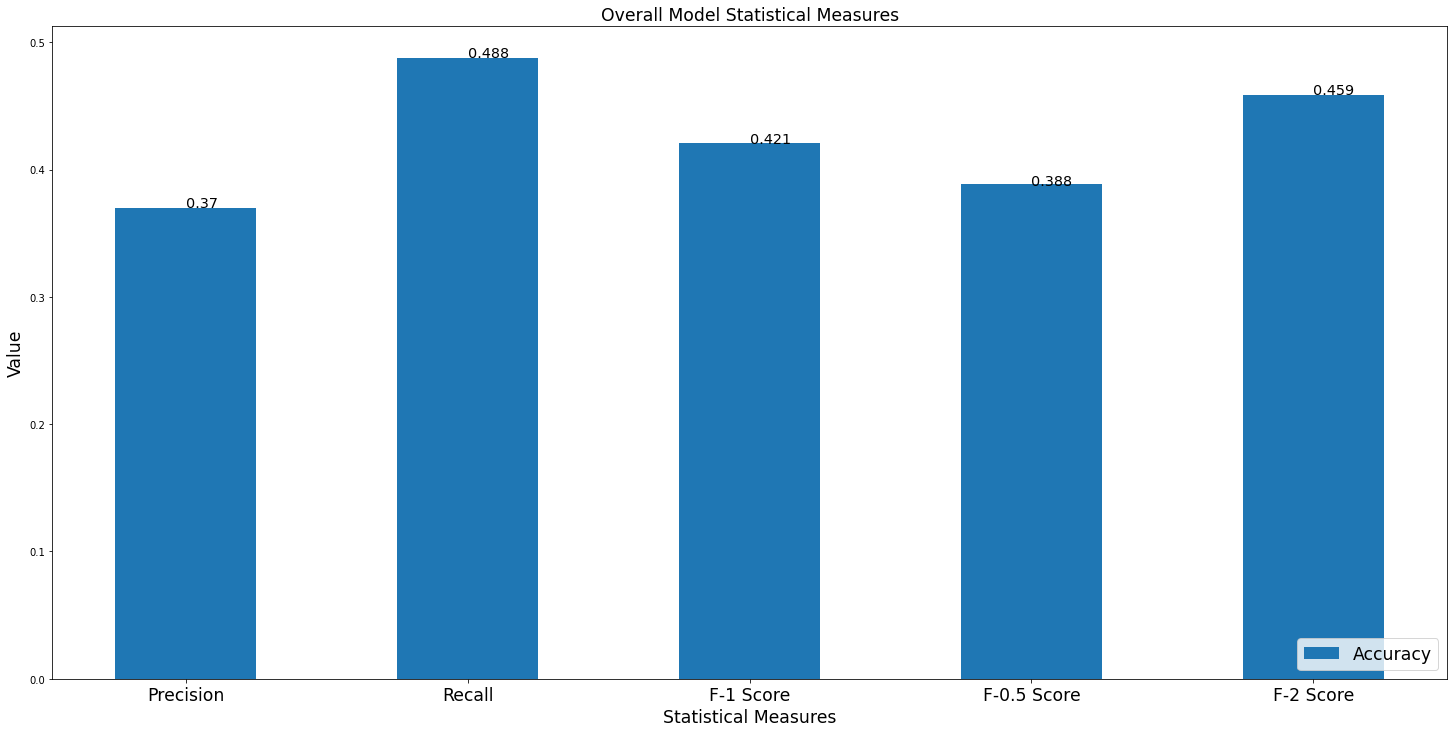

In [ ]:
# Plotting overall measures

def adding_labels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i],fontsize='x-large')
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [25, 12]


width = 0.5

bar_1 =np.arange(5)
plt.bar(bar_1,agg_overall_metric,width,label="Accuracy")


adding_labels(["Precision","Recall","F-1 Score","F-0.5 Score","F-2 Score"], [round(x,3) for x in agg_overall_metric])

plt.xlabel("Statistical Measures",fontsize='xx-large')
plt.ylabel("Value",fontsize='xx-large')
plt.title("Overall Model Statistical Measures",fontsize='xx-large')
plt.xticks(bar_1,["Precision","Recall","F-1 Score","F-0.5 Score","F-2 Score"],fontsize='xx-large')
plt.legend(loc='lower right',fontsize='xx-large')


In [ ]:
print(metrics.classification_report(actual_tags[0], predicted_tags[0]))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                    precision    recall  f1-score   support

                                                         0.97      0.73      0.84    109732
                                    a_battery.n.01       0.00      0.00      0.00         0
                                        a_bit.r.01       0.47      1.00      0.64        17
                                        a_few.s.01       0.58      1.00      0.73        36
                                   a_fortiori.r.01       1.00      1.00      1.00         1
                                      a_level.n.01       0.00      0.00      0.00         0
                                        a_lot.r.01       1.00      0.67      0.80         6
                                      abandon.v.01       0.33      1.00      0.50         1
                                      abandon.v.02       0.00      0.00      0.00         2
                                      abandon.v.04       1.00      0.50      0.